In [ ]:
import torch as torch
import torch.nn as nn
from typing import Optional
from math import floor, log2, sqrt
import torch.nn.functional as F

In [ ]:
class SoftMergingFFF(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim, depth, tree_act=nn.LogSigmoid(), topk=None, save_probs=False):
        super().__init__()
        self.save_probs, self.tree_act, self.depth = save_probs, tree_act, depth
        self.n = 2**depth
        self.topk = topk or self.n
        def uniform(shape, scale): 
            return nn.Parameter(torch.empty(shape).uniform_(-scale,scale))
        self.nodes = uniform((self.n-1, in_dim), scale=1/sqrt(in_dim))
        self.w1 = uniform((self.n, h_dim, in_dim), scale=1/sqrt(in_dim))
        self.w2 = uniform((self.n, out_dim, h_dim), scale=1/sqrt(h_dim))
        self.act = nn.ReLU()
        self.t = self.init_t_()

    def init_t_(self):
        tree, res = torch.eye(self.n), []
        for _ in range(self.depth): 
            res.append(tree)
            tree = tree.view(self.n, -1, 2).sum(-1)
        return nn.Parameter(torch.cat(list(reversed(res)),dim=1), False)

    def forward(self, x: torch.Tensor):
        bs = x.shape[0]
        if self.training:
            # get probs for each node
            z = x.matmul(self.nodes.T)
            z = self.tree_act(torch.stack([-z, z],dim=2)).matmul(self.t.T)
            probs = torch.softmax(probs, dim=-1)
        else:
            # select node with highest prob at each level
            indices = torch.zeros(bs, dtype=torch.long, device=x.device)
            for _ in range(self.depth):
                indices = indices*2 + 1 + (torch.einsum("bi,bi->b", x, self.nodes[indices])<0).long()
            # map to leaves that range from 0
            indices = indices - self.n+1
            probs = F.one_hot(indices, self.n)
        
        # save probs for debugging and visualization
        if self.save_probs: self.probs = torch.softmax(z,-1)
        
        # construct a merged expert in the first layer
        w1 = torch.einsum('bkxy,bk->bxy', self.w1.repeat(bs,1,1,1), probs)
        x = x[:,None].bmm(w1.T).squeeze(1)
        
        # similar for the next layer
        w2 = torch.einsum('bkxy,bk->bxy', self.w2.repeat(bs,1,1,1), probs)
        x = x[:,None].bmm(w2.T).squeeze(1)
        return x

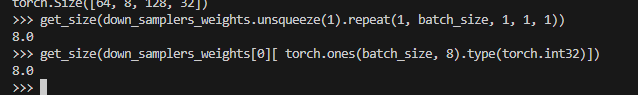

B = batch_size
M = n_routers
N = num_adapters
C = model_dim
down_size = down_size